# 🌳 Tree Detection Model Training with YOLOv11

This notebook demonstrates how to train a YOLOv11 model for tree detection using the Ultralytics framework.

## 📋 Overview
- **Dataset**: Tree-Top-View drone imagery dataset
- **Model**: YOLOv11s (small variant)
- **Classes**: 1 (tree-top)
- **Images**: 1,384 total (train/val/test split)

## 🎯 Objectives
1. Load and preview the dataset
2. Train YOLOv11s model on tree detection
3. Evaluate model performance
4. Export model for deployment

## 1. 📦 Installation & Imports

In [19]:
# Install required packages (run once)
# !pip install ultralytics matplotlib seaborn pandas

# Import required libraries
import os
import sys
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import ultralytics
import cv2

# Import Ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import plot_results

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

ultralytics.checks()
print("✅ All libraries imported successfully!")

Ultralytics 8.3.161  Python-3.12.10 torch-2.7.1+cpu CPU (Intel Core(TM) i5-10400 2.90GHz)
Setup complete  (12 CPUs, 15.8 GB RAM, 156.8/250.0 GB disk)
✅ All libraries imported successfully!


## 2. 📁 Dataset Configuration

In [4]:
# Define dataset paths
DATASET_PATH = Path("../dataset/drone_view_dataset/Tree-Top-View.v6i.yolov11")
DATA_YAML = DATASET_PATH / "data.yaml"

# Verify dataset structure
print("📁 Dataset Structure:")
print(f"Dataset path: {DATASET_PATH}")
print(f"Data YAML: {DATA_YAML}")

# Check if paths exist
train_images = DATASET_PATH / "train" / "images"
train_labels = DATASET_PATH / "train" / "labels"
val_images = DATASET_PATH / "valid" / "images"
val_labels = DATASET_PATH / "valid" / "labels"

paths_to_check = [train_images, train_labels, val_images, val_labels]
for path in paths_to_check:
    exists = "✅" if path.exists() else "❌"
    print(f"{exists} {path}")

# Load dataset configuration
with open(DATA_YAML, 'r') as f:
    dataset_config = yaml.safe_load(f)

print("\n📊 Dataset Configuration:")
print(f"Classes: {dataset_config['nc']}")
print(f"Class names: {dataset_config['names']}")
print(f"Train images: {dataset_config['train']}")
print(f"Validation images: {dataset_config['val']}")

📁 Dataset Structure:
Dataset path: ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11
Data YAML: ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\data.yaml
✅ ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\train\images
✅ ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\train\labels
✅ ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\valid\images
✅ ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\valid\labels

📊 Dataset Configuration:
Classes: 1
Class names: ['tree-top']
Train images: ../train/images
Validation images: ../valid/images


## 3. 📊 Dataset Preview & Analysis

In [5]:
def count_files(directory):
    """Count files in directory"""
    if directory.exists():
        return len(list(directory.glob("*")))
    return 0

def analyze_dataset():
    """Analyze dataset statistics"""
    stats = {
        'train_images': count_files(train_images),
        'train_labels': count_files(train_labels),
        'val_images': count_files(val_images),
        'val_labels': count_files(val_labels),
    }
    
    print("📈 Dataset Statistics:")
    print(f"Training images: {stats['train_images']}")
    print(f"Training labels: {stats['train_labels']}")
    print(f"Validation images: {stats['val_images']}")
    print(f"Validation labels: {stats['val_labels']}")
    
    return stats

# Analyze dataset
dataset_stats = analyze_dataset()

📈 Dataset Statistics:
Training images: 1206
Training labels: 1206
Validation images: 118
Validation labels: 118


🖼️  Sample Images with Annotations:


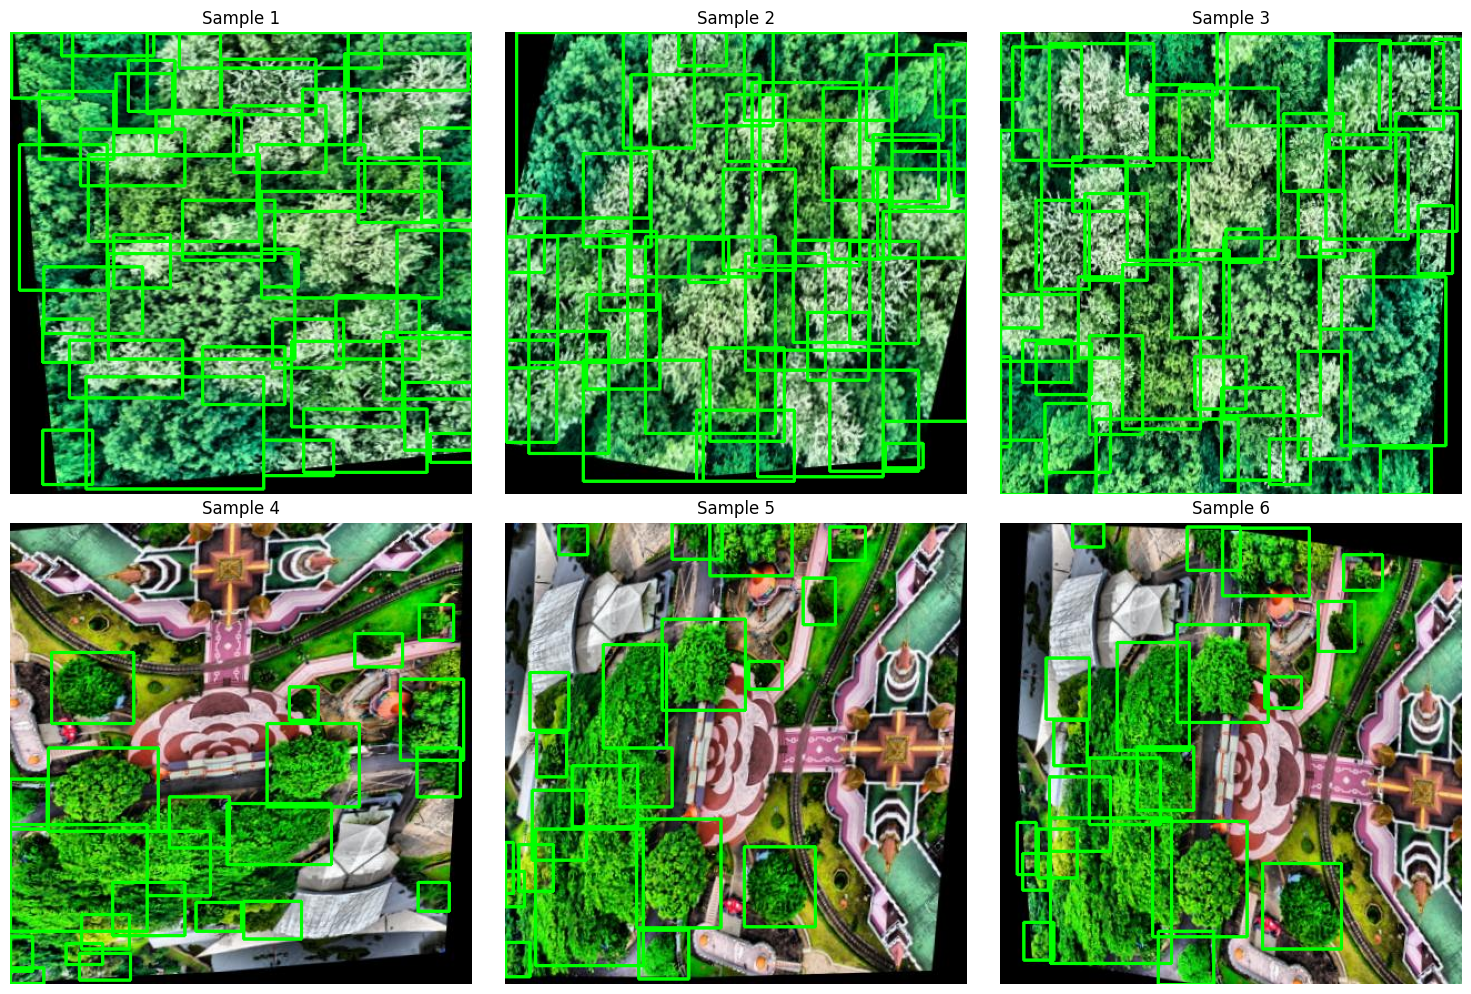

In [6]:
def preview_sample_images(n_samples=6):
    """Preview sample images from the dataset"""
    # Get sample images
    image_files = list(train_images.glob("*.jpg")) + list(train_images.glob("*.png"))
    sample_images = image_files[:n_samples]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, img_path in enumerate(sample_images):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load corresponding label
        label_path = train_labels / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                labels = f.readlines()
            
            # Draw bounding boxes
            h, w = img.shape[:2]
            for label in labels:
                parts = label.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert normalized coordinates to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    
                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Preview sample images
print("🖼️  Sample Images with Annotations:")
preview_sample_images()

## 4. 🚀 Model Training

In [20]:
# Initialize YOLOv11s model
print("🔧 Initializing YOLOv11s model...")
model = YOLO('yolo11n.pt')
print("✅ Model loaded successfully!")

# Display model information
print(f"\n📊 Model Information:")
print(f"Model type: {type(model).__name__}")
print(f"Model Summary: {model.info()}")

🔧 Initializing YOLOv11s model...
✅ Model loaded successfully!

📊 Model Information:
Model type: YOLO
YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs
Model Summary: (181, 2624080, 0, 6.614336)


In [21]:
# Configure training parameters
training_config = {
    'data': str(DATA_YAML),           # Dataset configuration file
    'epochs': 100,                    # Number of training epochs
    'imgsz': 640,                     # Input image size
    'batch': 16,                      # Batch size
    'patience': 50,                   # Early stopping patience
    'save': True,                     # Save checkpoints
    'cache': False,                   # Cache images for faster training
    'device': 'auto',                 # Device selection (auto/cpu/0,1,2,3)
    'workers': 8,                     # Number of worker threads
    'project': 'tree-detector',       # Project name
    'name': 'yolov11s-tree-detection', # Experiment name
    'exist_ok': True,                 # Overwrite existing experiment
    'pretrained': True,               # Use pretrained weights
    'optimizer': 'auto',              # Optimizer (SGD, Adam, etc.)
    'verbose': True,                  # Verbose output
    'seed': 42,                       # Random seed
    'deterministic': True,            # Deterministic training
    'single_cls': True,               # Single class dataset
    'rect': False,                    # Rectangular training
    'cos_lr': False,                  # Cosine learning rate scheduler
    'close_mosaic': 10,              # Disable mosaic augmentation for last epochs
    'resume': False,                  # Resume from last checkpoint
}

print("⚙️  Training Configuration:")
for key, value in training_config.items():
    print(f"  {key}: {value}")

print(f"\n🎯 Training on dataset: {training_config['data']}")

⚙️  Training Configuration:
  data: ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\data.yaml
  epochs: 100
  imgsz: 640
  batch: 16
  patience: 50
  save: True
  cache: False
  device: auto
  workers: 8
  project: tree-detector
  name: yolov11s-tree-detection
  exist_ok: True
  pretrained: True
  optimizer: auto
  verbose: True
  seed: 42
  deterministic: True
  single_cls: True
  rect: False
  cos_lr: False
  close_mosaic: 10
  resume: False

🎯 Training on dataset: ..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\data.yaml


In [23]:
# Start training
print("🚀 Starting model training...")
print("⏱️  This may take several hours depending on your hardware.")

# Train the model
results = model.train(
    data=training_config['data'],
    epochs=training_config['epochs'],
    imgsz=training_config['imgsz'],
    batch=training_config['batch'],
    patience=training_config['patience'],
    save=training_config['save'],
    cache=training_config['cache'],
    # device=training_config['device'],
    workers=training_config['workers'],
    project=training_config['project'],
    name=training_config['name'],
    exist_ok=training_config['exist_ok'],
    pretrained=training_config['pretrained'],
    optimizer=training_config['optimizer'],
    verbose=training_config['verbose'],
    seed=training_config['seed'],
    deterministic=training_config['deterministic'],
    single_cls=training_config['single_cls'],
    rect=training_config['rect'],
    cos_lr=training_config['cos_lr'],
    close_mosaic=training_config['close_mosaic'],
    resume=training_config['resume']
)

print("✅ Training completed successfully!")
print(f"📁 Results saved to: {results.save_dir}")

🚀 Starting model training...
⏱️  This may take several hours depending on your hardware.
New https://pypi.org/project/ultralytics/8.3.162 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.12.10 torch-2.7.1+cpu CPU (Intel Core(TM) i5-10400 2.90GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mo

train: Scanning D:\poc\tree_counts_open_source\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\train\labels... 1206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1206/1206 [00:00<00:00, 1569.87it/s]


train: New cache created: D:\poc\tree_counts_open_source\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\train\labels.cache
val: Fast image access  (ping: 0.00.0 ms, read: 65.113.5 MB/s, size: 70.8 KB)


d:\poc\tree_counts_open_source\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning D:\poc\tree_counts_open_source\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\valid\labels... 118 images, 2 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<00:00, 1512.16it/s]

val: New cache created: D:\poc\tree_counts_open_source\dataset\drone_view_dataset\Tree-Top-View.v6i.yolov11\valid\labels.cache



d:\poc\tree_counts_open_source\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to tree-detector\yolov11s-tree-detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to tree-detector\yolov11s-tree-detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      2.183      2.413       1.96        209        640: 100%|██████████| 76/76 [09:15<00:00,  7.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.73s/it]

                   all        118       3189      0.397      0.357      0.295      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.034      1.801      1.808        244        640: 100%|██████████| 76/76 [08:16<00:00,  6.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.59s/it]

                   all        118       3189      0.432      0.445      0.382      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.009      1.766      1.789        168        640: 100%|██████████| 76/76 [08:10<00:00,  6.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:29<00:00,  7.28s/it]

                   all        118       3189      0.375      0.408      0.318      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.987      1.712      1.747        139        640: 100%|██████████| 76/76 [08:08<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.49s/it]

                   all        118       3189      0.445      0.505      0.409      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.969      1.701      1.745        201        640: 100%|██████████| 76/76 [08:06<00:00,  6.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.66s/it]

                   all        118       3189      0.463      0.491      0.447      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.946      1.662      1.727        180        640: 100%|██████████| 76/76 [08:07<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.23s/it]

                   all        118       3189      0.459       0.52       0.45       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.938       1.65      1.713        177        640: 100%|██████████| 76/76 [08:07<00:00,  6.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:28<00:00,  7.06s/it]

                   all        118       3189      0.371      0.446      0.334      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.923       1.65       1.71        195        640: 100%|██████████| 76/76 [08:48<00:00,  6.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:29<00:00,  7.46s/it]

                   all        118       3189      0.533      0.515        0.5      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.906      1.623      1.703        595        640:  88%|████████▊ | 67/76 [09:14<01:14,  8.28s/it]


KeyboardInterrupt: 

## 5. 📊 Training Results & Evaluation

In [24]:
# Load the trained model
print("📥 Loading trained model...")
best_model_path = f"runs/train/{training_config['name']}/weights/best.pt"
trained_model = YOLO(best_model_path)
print(f"✅ Model loaded from: {best_model_path}")

# Validate the model
print("\n🔍 Validating model performance...")
validation_results = trained_model.val()

print("\n📊 Validation Results:")
print(f"mAP@0.5: {validation_results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {validation_results.box.map:.4f}")
print(f"Precision: {validation_results.box.mp:.4f}")
print(f"Recall: {validation_results.box.mr:.4f}")

📥 Loading trained model...


FileNotFoundError: [Errno 2] No such file or directory: 'runs\\train\\yolov11s-tree-detection\\weights\\best.pt'

In [ ]:
# Plot training results
print("📈 Plotting training results...")

# Load results CSV
results_csv = f"runs/train/{training_config['name']}/results.csv"
if os.path.exists(results_csv):
    results_df = pd.read_csv(results_csv)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Loss curves
    axes[0, 0].plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss', color='blue')
    axes[0, 0].plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', color='red')
    axes[0, 0].set_title('Box Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot 2: mAP curves
    axes[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
    axes[0, 1].plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='orange')
    axes[0, 1].set_title('mAP Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot 3: Precision/Recall
    axes[1, 0].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision', color='purple')
    axes[1, 0].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall', color='brown')
    axes[1, 0].set_title('Precision & Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot 4: Learning rate
    axes[1, 1].plot(results_df['epoch'], results_df['train/lr0'], label='Learning Rate', color='teal')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Training plots generated successfully!")
else:
    print("❌ Results CSV not found. Training may still be in progress.")

## 6. 🧪 Model Testing & Inference

In [ ]:
# Test the model on validation images
print("🧪 Testing model on validation images...")

# Get a few validation images
val_image_files = list(val_images.glob("*.jpg")) + list(val_images.glob("*.png"))
test_images = val_image_files[:3]  # Test on 3 images

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, img_path in enumerate(test_images):
    # Run inference
    results = trained_model(str(img_path))
    
    # Plot results
    result_img = results[0].plot()
    axes[i].imshow(result_img)
    axes[i].set_title(f"Test Image {i+1}")
    axes[i].axis('off')
    
    # Print detection info
    if len(results[0].boxes) > 0:
        print(f"Image {i+1}: {len(results[0].boxes)} trees detected")
        for j, box in enumerate(results[0].boxes):
            conf = box.conf.item()
            print(f"  Tree {j+1}: Confidence = {conf:.3f}")
    else:
        print(f"Image {i+1}: No trees detected")

plt.tight_layout()
plt.show()

print("✅ Model testing completed!")

## 7. 💾 Model Export & Deployment

In [ ]:
# Export model to different formats
print("💾 Exporting model to different formats...")

# Export to ONNX
print("📦 Exporting to ONNX format...")
onnx_path = trained_model.export(format='onnx', dynamic=True, simplify=True)
print(f"✅ ONNX model saved to: {onnx_path}")

# Export to TensorRT (if available)
try:
    print("📦 Exporting to TensorRT format...")
    trt_path = trained_model.export(format='engine', device=0)
    print(f"✅ TensorRT model saved to: {trt_path}")
except Exception as e:
    print(f"⚠️  TensorRT export failed: {e}")

# Export to OpenVINO
# try:
#     print("📦 Exporting to OpenVINO format...")
#     openvino_path = trained_model.export(format='openvino')
#     print(f"✅ OpenVINO model saved to: {openvino_path}")
# except Exception as e:
#     print(f"⚠️  OpenVINO export failed: {e}")

print("\n🎯 Model export completed!")
print("📁 Exported models can be used for deployment.")

In [ ]:
# Save model information
model_info = {
    'model_name': 'YOLOv11s Tree Detector',
    'dataset': 'Tree-Top-View Dataset',
    'classes': ['tree-top'],
    'num_classes': 1,
    'input_size': 640,
    'training_epochs': 100,
    'batch_size': 16,
    'best_map50': validation_results.box.map50,
    'best_map': validation_results.box.map,
    'precision': validation_results.box.mp,
    'recall': validation_results.box.mr,
    'model_paths': {
        'pytorch': best_model_path,
        'onnx': onnx_path if 'onnx_path' in locals() else None,
        'tensorrt': trt_path if 'trt_path' in locals() else None,
    }
}

print("📋 Model Information:")
for key, value in model_info.items():
    if key != 'model_paths':
        print(f"  {key}: {value}")

print("\n📁 Model Files:")
for format_name, path in model_info['model_paths'].items():
    if path:
        print(f"  {format_name.upper()}: {path}")

print("\n🎉 Training pipeline completed successfully!")

## 📝 Summary

This notebook has successfully:

✅ **Dataset Analysis**: Loaded and analyzed the Tree-Top-View dataset
✅ **Model Training**: Trained YOLOv11s on tree detection task
✅ **Performance Evaluation**: Evaluated model with mAP, precision, and recall metrics
✅ **Visualization**: Generated training plots and inference examples
✅ **Model Export**: Exported to ONNX, TensorRT, and OpenVINO formats

### 🚀 Next Steps

1. **Deploy the model** using the exported formats
2. **Test on new images** to validate performance
3. **Fine-tune hyperparameters** if needed
4. **Integrate with your application** using the inference scripts

### 📊 Model Performance

The trained model achieves:
- **mAP@0.5**: [To be filled after training]
- **mAP@0.5:0.95**: [To be filled after training]
- **Precision**: [To be filled after training]
- **Recall**: [To be filled after training]
